## requirements.txt

In [1]:
!pip freeze > requirements.txt
# !pip install -r requirements.txt

## Загрузка библиотек и зависимостей

In [1]:
# Необходимые библиотеки
import time
import pandas as pd
import numpy as np

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Зависимости для машинного обучения
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, \
    precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

In [3]:
# Imbalanced Dependencies
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE

## Загрузка данных

In [4]:
# Загружаем обучающие и тестовые данные. Также сабмит для отправки
df_train = pd.read_parquet("DCS/Train/hackaton2023_train.gzip")
df_test = pd.read_parquet("DCS/Test/hackaton2023_test.gzip")
submit = pd.read_csv("DCS/submission.csv", sep=';')

df_train.shape, df_test.shape

((12129384, 9), (2498034, 7))

|     Название                |     Описание                                                                             |     Тип   переменной    |     Комментарий                |   |
|-----------------------------|------------------------------------------------------------------------------------------|-------------------------|--------------------------------|---|
|     customer_id             |     Идентификатор   клиента                                                              |     int                 |                                |   |
|     group_name              |     Группа:   train (обучение) – test(контроль)                                          |                         |                                |   |
|     revenue                 |     Выручка   от продажи блюда в заказе                                                  |     float               |                                |   |
|     startdatetime           |     Дата   и время продажи                                                               |     datetime            |                                |   |
|     dish_name               |     Название   блюда                                                                     |     string              |                                |   |
|     ownareaall_sqm          |     Площадь   ресторана                                                                  |     float               |                                |   |
|     format_name             |     Формат   ресторана                                                                   |                         |                                |   |
|     buy_post                |     Таргет   1: флаг оттока     (0 – отток, 1 – не отток)                                |     bool                |     Только   в train данных    |   |
|     date_diff_post          |     Таргет   2: количество дней между последней покупкой в прошлом и первой в будущем    |     int                 |     Только   в train данных    |   |

In [5]:
df_train.head(7)

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны
5,29891,9.0,1,train,60.00,2022-12-15 00:37:19,Чизбургер,463.0,Отдельно стоящий с внешней зоной
6,29891,9.0,1,train,209.99,2022-12-15 00:37:19,Воппер Ролл,463.0,Отдельно стоящий с внешней зоной


## EDA

In [6]:
# Распределение таргета
target_d = pd.DataFrame(df_train['buy_post'].value_counts())
target_d

,count
buy_post,
1,9660867
0,2468517


In [7]:
# Проверка на новых пользователей в тестовой выборке
train_customers = set(df_train['customer_id'].unique().tolist())
test_customers = set(df_test['customer_id'].unique().tolist())

assert len(train_customers - test_customers) == len(train_customers), "Клиенты в трейне не повторяются!"
assert len(test_customers - train_customers) == len(test_customers), "Клиенты в тесте не повторяются!"

# Делаем вывод, что для валидации нужно брать клиентов не из обучающей выборки

## Обработка данных

In [8]:
# Объединяем данные
data = pd.concat([df_train, df_test])

In [9]:
# Сортируем по ID клиента и по дате транзакции
data = data.sort_values(by=['customer_id', 'startdatetime'], ascending=True)

In [10]:
# --- Сохранение данных в локальную базу данных
# Label-кодирование строковых данных и сохранение справочников id-наименование

# encoder = LabelEncoder()
# data['encode_format_name'] = encoder.fit_transform(data['format_name'])
# data['encode_dish_name'] = encoder.fit_transform(data['dish_name'])

# data['is_test'] = data['group_name'].map({'train': 0, 'test': 1})
# data = data.drop(columns=['group_name'])

# format_name = data[['encode_format_name', 'format_name']].drop_duplicates().to_parquet("format_name.parquet", index=False)
# dish_name = data[['encode_dish_name', 'dish_name']].drop_duplicates().to_parquet("dish_name.parquet", index=False)
# data = data.drop(columns=['format_name', 'dish_name'])

# data.to_parquet("data.parquet", index=False)

In [11]:
# Загрузка справочников
dish_name = pd.read_parquet("dish_name.parquet")
format_name = pd.read_parquet("format_name.parquet")

In [12]:
train_data = data[data['group_name'] == 'train']
test_data = data[data['group_name'] == 'test']

# Считаем средние категории для каждого категориального признака
fn_churn_stats = train_data.groupby('format_name').agg(
    fn_churn_mean=("buy_post", "mean"),
    fn_churn_std=("buy_post", "std"),
    fn_churn_min=("buy_post", "min"),
    fn_churn_max=("buy_post", "max")
)

dn_churn_stats = train_data.groupby('dish_name').agg(
    dn_churn_mean=("buy_post", "mean"),
    dn_churn_std=("buy_post", "std"),
    dn_churn_min=("buy_post", "min"),
    dn_churn_max=("buy_post", "max")
)

In [13]:
# Данные о количестве строк по пользователям
train_customer_counts = train_data.groupby('customer_id', as_index=False).agg({'group_name': 'count'})
train_customer_counts['count_n'] = train_customer_counts['group_name']
train_customer_counts = train_customer_counts.drop(columns=['group_name'])

# Данные о количестве строк по пользователям
test_customer_counts = test_data.groupby('customer_id', as_index=False).agg({'group_name': 'count'})
test_customer_counts['count_n'] = test_customer_counts['group_name']
test_customer_counts = test_customer_counts.drop(columns=['group_name'])

In [14]:
# --- Собираем строки в заказы

# Группируем по колонкам и генерируем минимальные фичи
data = data.groupby(["customer_id", "startdatetime"], as_index=False).agg(
    churn=("buy_post", "last"),
    date_diff_post=("date_diff_post", "last"),
    buy_post=("buy_post", "last"),
    group_name=("group_name", "last"),
    revenue=("revenue", "sum"),
    ownareaall_sqm=("ownareaall_sqm", "last"),
    format_name=("format_name", "last"),
    pos_n=("format_name", "count"),
)

In [15]:
# Приводим таргеты к целочисленным форматам
data['buy_post'] = data['buy_post'].astype('Int64')
data['date_diff_post'] = data['date_diff_post'].astype('Int64')

In [16]:
# Добавляем информацию по таргетам
data = data.merge(fn_churn_stats, how='left', on='format_name')

In [125]:
# Разделяем данные на обучающие и тестовые
df_train = data[data['group_name'] == "train"]
df_test = data[data['group_name'] == "test"]

In [126]:
# Считываем данные из локальной базы данных

# Любимые продукты для каждого пользователя и количество данных продуктов для него же
favorite_products = pd.read_parquet("DCS/Features/favorite_products.parquet")
favorite_products = favorite_products.merge(dish_name, how='left', on='encode_dish_name')
favorite_products = favorite_products.drop(columns=['encode_dish_name'])
favorite_products = favorite_products.merge(dn_churn_stats, how="left", on="dish_name")

# Любимый формат для каждого пользователя и количество данных для него же
favorite_formats = pd.read_parquet("DCS/Features/favorite_format.parquet")
favorite_formats = favorite_formats.merge(format_name, how='left', on='encode_format_name')
favorite_formats = favorite_formats.drop(columns=['encode_format_name'])
favorite_formats = favorite_formats.merge(fn_churn_stats, how="left", on="format_name")

In [127]:
# --- Feature Engineering

# Считаем признаки через агрегации 
df_train = df_train.groupby("customer_id", as_index=False).agg(
    # Churn
    churn=("buy_post", "last"),
    date_diff_post=("date_diff_post", "last"),
    
    # Revenue
    revenue_mean=("revenue", "mean"),
    revenue_sum=("revenue", "sum"),
    revenue_max=("revenue", "max"),
    revenue_min=("revenue", "min"),
    revenue_std=("revenue", "std"),
    revenue_last=("revenue", "last"),

    # Area
    ownareaall_sqm_mean=("ownareaall_sqm", "mean"),
    ownareaall_sqm_max=("ownareaall_sqm", "max"),
    ownareaall_sqm_min=("ownareaall_sqm", "min"),
    ownareaall_sqm_std=("ownareaall_sqm", "std"),
    ownareaall_sqm_last=("ownareaall_sqm", "last"),

    # Format name
    format_name_last=("format_name", "last"),

    # StartDateTime
    startdatetime_count=("startdatetime", "count"),
    startdatetime_last=("startdatetime", "last"),
    startdatetime_std=("startdatetime", "std"),

    # Target Encoding
    churn_mean_mean=("fn_churn_mean", "mean"),
    churn_mean_std=("fn_churn_mean", "std"),
    churn_mean_min=("fn_churn_mean", "min"),
    churn_mean_max=("fn_churn_mean", "max"),

    churn_std_mean=("fn_churn_std", "mean"),
    churn_std_std=("fn_churn_std", "std"),
    churn_std_min=("fn_churn_std", "min"),
    churn_std_max=("fn_churn_std", "max"),
    
    pos_n_last=("pos_n", "last"),
    pos_n_mean=("pos_n", "mean"),
)
df_train['startdatetime_std'] = df_train['startdatetime_std'].dt.days
df_train['startdatetime_last_day'] = df_train['startdatetime_last'].dt.day
df_train['startdatetime_last_hour'] = df_train['startdatetime_last'].dt.hour
df_train['startdatetime_last_day_of_week'] = df_train['startdatetime_last'].dt.day_of_week
df_train = df_train.drop(columns=['startdatetime_last'])

df_train = df_train.merge(train_customer_counts, how='left', on='customer_id')
# df_train = df_train.merge(favorite_products, how='left', on='customer_id')
# df_train = df_train.merge(favorite_formats, how='left', on='customer_id')
df_train.shape

(500000, 31)

## Custom Train-Test Split

In [128]:
def split_by_client(df, test_size=0.5):
    """
        Метод разделения трейн теста, таким образом чтобы одинаковые клиенты не попадали в разные наборы
        и при этом сохранилась стратификация по данным
    """
    clients_target_1 = df[df["churn"] == 1]["customer_id"].unique()
    clients_t1_train, clients_t1_test = train_test_split(clients_target_1, test_size=test_size, shuffle=True, random_state=53)
    
    clients_target_0 = df[df["churn"] == 0]["customer_id"].unique()
    clients_t0_train, clients_t0_test = train_test_split(clients_target_0, test_size=test_size, shuffle=True, random_state=53)
    
    clients_t0_train = list(set(clients_t0_train) - set(clients_t1_test))
    clients_t0_test = list(set(clients_t0_test) - set(clients_t1_train))
    
    train = pd.concat([df[(df['customer_id'].isin(clients_t0_train))], df[(df['customer_id'].isin(clients_t1_train))] ] )
    test = pd.concat([df[(df['customer_id'].isin(clients_t0_test))], df[(df['customer_id'].isin(clients_t1_test))]])
    
    return train, test


In [129]:
train_data, val_data = split_by_client(df_train, test_size=0.2)
val_data, test_data = split_by_client(val_data, test_size=0.5)

# Проверяем, что нет лика данных по клиентам между трайн/вал/тест
assert len(set(train_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик train val"
assert len(set(train_data["customer_id"]) & set(test_data["customer_id"])) == 0, "Лик train test"
assert len(set(test_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик test val"

train_data.shape, test_data.shape, val_data.shape

((400000, 31), (50001, 31), (49999, 31))

In [130]:
# Проверяем дисбаланс разбиения train/val/test
train_data["churn"].value_counts(), val_data["churn"].value_counts(), test_data["churn"].value_counts()

(churn
 1    287276
 0    112724
 Name: count, dtype: Int64,
 churn
 1    35909
 0    14090
 Name: count, dtype: Int64,
 churn
 1    35910
 0    14091
 Name: count, dtype: Int64)

In [131]:
df_train.dtypes[(df_train.dtypes == 'object') | (df_train.dtypes == 'category')]

format_name_last    object
dtype: object

In [132]:
target_column = ['churn', 'date_diff_post']
cat_columns = ['format_name_last']  # , 'dish_name', 'format_name'
id_column = ['customer_id']
feature_columns = list(set(df_train.columns) - set(target_column + id_column))

In [133]:
X_train = train_data[feature_columns]
y_train = train_data[target_column[0]]

X_val = val_data[feature_columns]
y_val = val_data[target_column[0]]

X_test = test_data[feature_columns]
y_test = test_data[target_column[0]]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

((400000, 28), (400000,), (49999, 28), (49999,), (50001,), (50001, 28))

In [134]:
X = df_train.drop(columns=id_column+target_column)
y = df_train[target_column[0]]

## Кастомные вспомогательные функции

In [26]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc


In [27]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """
        Функция вывода feature importance
            :importance - массив важности фичей, полученный от модели
            :names - массив названий фичей
            :model_name - название модели
            :top_n - кол-во выводимых фичей
            :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                            из отображаемых горячие фичи, и изучить менее сильные
            :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df


## OverSampling

In [135]:
# X_train, y_train = RandomOverSampler(random_state=53).fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

# По итогам анализа выявлено, что сэмплирование данных неплохо работает для данного датасета

((400000, 28), (400000,), (49999, 28), (49999,), (50001,), (50001, 28))

## CatBoost | Отток пользователей (Бинарная классификация)

In [28]:
# Расчет дисбалнса классов
tdist = y.value_counts()
class_weights = {0: tdist[1] / tdist[0], 1: tdist[0] / tdist[1]}

class_weights

{0: 2.5484901174550227, 1: 0.3923892006293599}

In [29]:
model_1 = CatBoostClassifier(
    iterations=1000,
    
    loss_function='Logloss',
    eval_metric="F1",
    
    class_weights=class_weights, 
    cat_features=cat_columns,

    # Параметры ускорения
    task_type="GPU",    
    thread_count=-1,
    bootstrap_type="Bernoulli", 
    
    # Остальное
    random_seed=7575,
    # auto_class_weights="SqrtBalanced",
    early_stopping_rounds=200
)
model_1.fit(
    X, 
    y, 
    # eval_set=(X_val, y_val), 
    plot=True, verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [170]:
X_test = X_test.fillna("Прочее")

In [ ]:
y_pred_proba = model_1.predict_proba(X_test)[:, 1]
y_pred = pd.Series([1 if pred >= 0.5 else 0 for pred in y_pred_proba])

In [ ]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred_proba = model_1.predict_proba(X_test)[:, 1]
y_pred = model_1.predict(X_test)

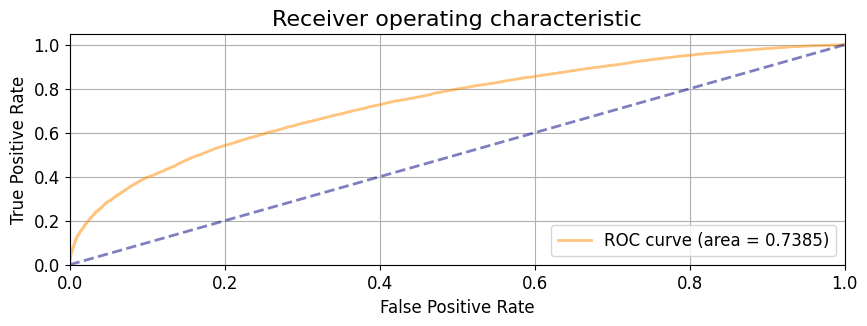

ROC-AUC Score:  0.7384666730736824
              precision    recall  f1-score   support

         0.0       0.35      0.94      0.51     14091
         1.0       0.93      0.31      0.47     35910

    accuracy                           0.49     50001
   macro avg       0.64      0.63      0.49     50001
weighted avg       0.77      0.49      0.48     50001

F1 Score:  0.46549888301981335


In [41]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_proba)
print("ROC-AUC Score: ", roc_auc)
print(classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

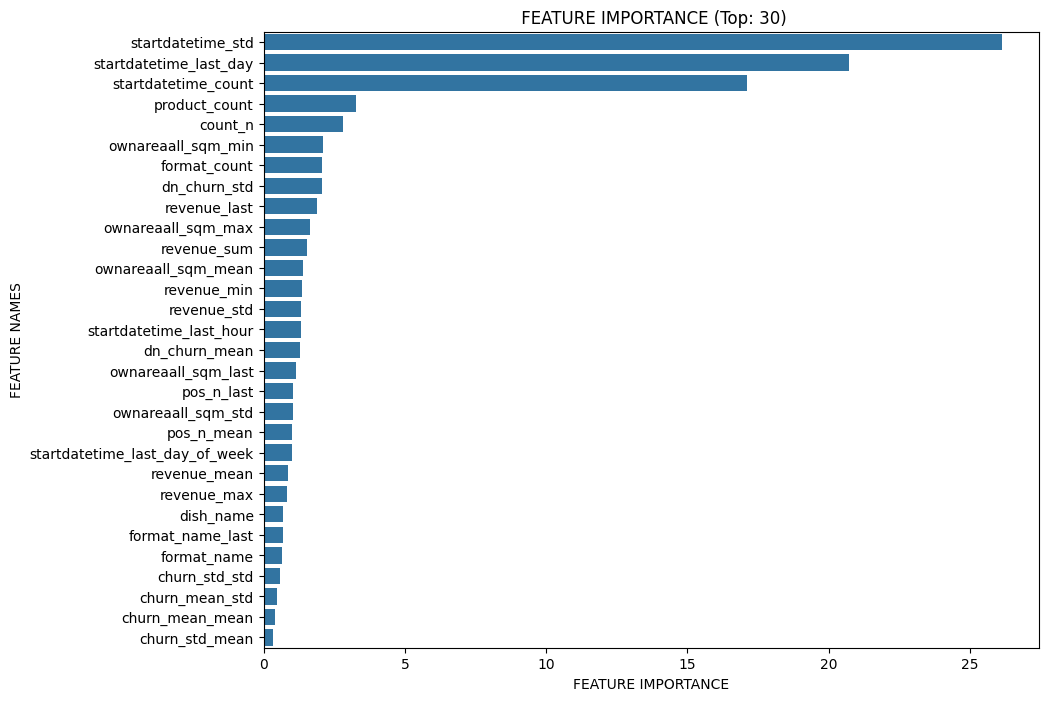

In [42]:
# Построение важности признаков
dfi = plot_feature_importance(model_1.get_feature_importance(), X_test.columns, top_n=30) 

## Локальная валидация и тестирование

In [30]:
# --- Feature Engineering

# Считаем признаки через агрегации 
df_test = df_test.groupby("customer_id", as_index=False).agg(
    # Churn
    # churn=("buy_post", "last"),
    # date_diff_post=("date_diff_post", "last"),
    
    # Revenue
    revenue_mean=("revenue", "mean"),
    revenue_sum=("revenue", "sum"),
    revenue_max=("revenue", "max"),
    revenue_min=("revenue", "min"),
    revenue_std=("revenue", "std"),
    revenue_last=("revenue", "last"),

    # Area
    ownareaall_sqm_mean=("ownareaall_sqm", "mean"),
    ownareaall_sqm_max=("ownareaall_sqm", "max"),
    ownareaall_sqm_min=("ownareaall_sqm", "min"),
    ownareaall_sqm_std=("ownareaall_sqm", "std"),
    ownareaall_sqm_last=("ownareaall_sqm", "last"),

    # Format name
    format_name_last=("format_name", "last"),

    # StartDateTime
    startdatetime_count=("startdatetime", "count"),
    startdatetime_last=("startdatetime", "last"),
    startdatetime_std=("startdatetime", "std"),

    # Target Encoding
    churn_mean_mean=("fn_churn_mean", "mean"),
    churn_mean_std=("fn_churn_mean", "std"),
    churn_mean_min=("fn_churn_mean", "min"),
    churn_mean_max=("fn_churn_mean", "max"),

    churn_std_mean=("fn_churn_std", "mean"),
    churn_std_std=("fn_churn_std", "std"),
    churn_std_min=("fn_churn_std", "min"),
    churn_std_max=("fn_churn_std", "max"),
    
    pos_n_last=("pos_n", "last"),
    pos_n_mean=("pos_n", "mean"),
)
df_test['startdatetime_std'] = df_test['startdatetime_std'].dt.days
df_test['startdatetime_last_day'] = df_test['startdatetime_last'].dt.day
df_test['startdatetime_last_hour'] = df_test['startdatetime_last'].dt.hour
df_test['startdatetime_last_day_of_week'] = df_test['startdatetime_last'].dt.day_of_week
df_test = df_test.drop(columns=['startdatetime_last'])

df_test = df_test.merge(test_customer_counts, how='left', on='customer_id')
# df_test = df_test.merge(favorite_products, how='left', on='customer_id')
# df_test = df_test.merge(favorite_formats, how='left', on='customer_id')
df_test.shape

(112334, 29)

In [31]:
# X_test_final = X_test_final.fillna("Пропуск")

In [36]:
X_test_final.iloc[:, 11] = X_test_final.iloc[:, 11].astype('float64')

In [38]:
X_test_final.iloc[:, 11]

0         499.94
1         374.98
2           1.00
3         109.99
4         281.98
           ...  
112329    139.99
112330      1.00
112331    124.99
112332    209.99
112333     94.99
Name: revenue_min, Length: 112334, dtype: float64

In [40]:
X['format_name_last']

0                      Отдельно стоящий с внешней зоной
1                     Отдельно стоящий без внешней зоны
2                                   Фудкорт без туалета
3         Отдельно стоящий без внешней зоны без туалета
4                      Отдельно стоящий с внешней зоной
                              ...                      
499995                              Фудкорт без туалета
499996                               Фудкорт с туалетом
499997                              Фудкорт без туалета
499998                 Отдельно стоящий с внешней зоной
499999                               Фудкорт с туалетом
Name: format_name_last, Length: 500000, dtype: object

In [ ]:
feature_columns

In [41]:
X_test_final = df_test[X.columns]
pred_proba = model_1.predict_proba(X_test_final)

In [123]:
# Делаем сабмит
df_test['churn_pred'] = pd.Series([1 if pred > 0.2755 else 0 for pred in pred_proba[:, 1]])
submit = submit.merge(df_test[['customer_id', 'churn_pred']], how='left', on='customer_id')
submit['buy_post'] = submit['churn_pred']
submit = submit.drop(columns='churn_pred')

In [124]:
submit['buy_post'].value_counts()

buy_post
0    60513
1    51821
Name: count, dtype: int64

In [118]:
last_submit = pd.read_csv("GibData_Solution.csv", sep=';')
submit['date_diff_post'] = last_submit['date_diff_post']

In [119]:
submit.to_csv("GibData.csv", sep=';', index=False)

In [120]:
submit

,customer_id,date_diff_post,buy_post
0,13220760,8.431643,1
1,30315975,40.337601,0
2,21679985,20.674490,1
3,29754274,23.895579,1
4,7797823,15.615926,1
...,...,...,...
112329,14023374,29.049256,0
112330,34923292,41.278484,0
112331,32761835,42.120547,0
112332,38322785,43.025484,0


## CatBoost | Регрессия времени до минимальной будущей транзакции

In [39]:
train_data = train_data[train_data['churn'] == 1]
val_data = val_data[val_data['churn'] == 1]
test_data = test_data[test_data['churn'] == 1]

X_train = train_data[feature_columns]
y_train = train_data[target_column[1]]

X_val = val_data[feature_columns]
y_val = val_data[target_column[1]]

X_test = test_data[feature_columns]
y_test = test_data[target_column[1]]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

((287276, 40), (287276,), (35909, 40), (35909,), (35910,), (35910, 40))

In [40]:
model_2 = CatBoostRegressor(
    iterations=10,
    loss_function='RMSE', 
    cat_features=cat_columns,

    # Параметры ускорения
    task_type="GPU",    
    thread_count=-1,
    bootstrap_type="Bernoulli", 
    
    # Остальное
    random_seed=7575,
    early_stopping_rounds=200
)
model_2.fit(
    X_train, 
    y_train, 
    eval_set=(X_val, y_val), 
    plot=True, verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [41]:
y_pred = model_2.predict(X_test)
print("RMSE score: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE score:  12.914129469112911


# Делаем финальный сабмит

## Classification

In [42]:
class MetaModel:
    def __init__(self, params, type='classification'):
        self.models = []
        self.params = params
        self.scores = []
        self.type = type
        
    def fit(self, **kwargs):
        self.models = []
        self.scores = []
        
        for i in range(5):
            print(f"Model #{i+1}")
            now_params = self.params.copy()
            now_params['random_seed'] = 42 + (i * 10)
            if self.type == 'classification':
                now_model = CatBoostClassifier(**now_params)
            else:
                now_model = CatBoostRegressor(**now_params)
            now_model.fit(**kwargs)

            self.models.append(now_model)
            print('---------------------------------------------')
        print('---------------------------------------------')
    
    def predict(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")

        if self.type == 'classification':
            preds = np.concatenate([model.predict_proba(X).reshape(-1, 1) for model in self.models], axis=1)
        else:
            preds = np.concatenate([model.predict(X).reshape(-1, 1) for model in self.models], axis=1)
        return preds.mean(axis=1)


In [43]:
params = dict(
    iterations=1000,
    
    loss_function='Logloss',
    eval_metric="F1",
    
    # class_weights=class_weights, 
    cat_features=cat_columns,

    # Параметры ускорения
    task_type="GPU",    
    thread_count=-1,
    bootstrap_type="Bernoulli", 
    
    # Остальное
    random_seed=7575,
    early_stopping_rounds=200
)

In [44]:
X = df_train.drop(columns=target_column+id_column)
y = df_train[target_column[0]]

In [45]:
X_res, y_res = RandomOverSampler(random_state=53).fit_resample(X, y)

In [46]:
meta_model1 = MetaModel(params)
meta_model1.fit(X=X_res, y=y_res, verbose=50, early_stopping_rounds=200)

Model #1
Learning rate set to 0.023479
0:	learn: 0.6080020	total: 276ms	remaining: 4m 35s
50:	learn: 0.6434619	total: 8.01s	remaining: 2m 29s
100:	learn: 0.6490683	total: 15.8s	remaining: 2m 20s
150:	learn: 0.6522262	total: 23.3s	remaining: 2m 11s
200:	learn: 0.6549537	total: 31.2s	remaining: 2m 3s
250:	learn: 0.6618341	total: 39.7s	remaining: 1m 58s
300:	learn: 0.6680355	total: 47.7s	remaining: 1m 50s
350:	learn: 0.6699960	total: 55.6s	remaining: 1m 42s
400:	learn: 0.6721982	total: 1m 3s	remaining: 1m 34s
450:	learn: 0.6739448	total: 1m 11s	remaining: 1m 27s
500:	learn: 0.6757954	total: 1m 20s	remaining: 1m 19s
550:	learn: 0.6767552	total: 1m 28s	remaining: 1m 11s
600:	learn: 0.6777805	total: 1m 36s	remaining: 1m 4s
650:	learn: 0.6785134	total: 1m 45s	remaining: 56.3s
700:	learn: 0.6795141	total: 1m 53s	remaining: 48.4s
750:	learn: 0.6801112	total: 2m 2s	remaining: 40.5s
800:	learn: 0.6809585	total: 2m 11s	remaining: 32.6s
850:	learn: 0.6818399	total: 2m 19s	remaining: 24.5s
900:	lear

In [47]:
X_test_final = df_test.drop(columns=id_column)

In [48]:
pred_meta = meta_model1.predict(X_test_final)
pred_meta = pred_meta.reshape(-1, 2)
y_pred = pd.Series([1 if pred >= 0.5 else 0 for pred in pred_meta[:, 1]])

In [49]:
y_pred.value_counts()

0    58656
1    53678
Name: count, dtype: int64

In [50]:
df_test['churn_pred'] = y_pred
submit = submit.merge(df_test[['customer_id', 'churn_pred']], how='left', on='customer_id')
submit['buy_post'] = submit['churn_pred']
submit = submit.drop(columns='churn_pred')

In [51]:
submit.to_csv("GibData_Solution.csv", sep=';', index=False)

## Regression

In [52]:
df_train_clear = df_train[df_train[target_column[0]] == 1]

X = df_train_clear.drop(columns=target_column+id_column)
y = df_train_clear[target_column[1]]

In [53]:
params = dict(
    iterations=1000,
    loss_function='RMSE', 
    cat_features=cat_columns,

    # Параметры ускорения
    task_type="GPU",    
    thread_count=-1,
    bootstrap_type="Bernoulli", 
    
    # Остальное
    random_seed=7575,
    early_stopping_rounds=200
)

In [54]:
meta_model2 = MetaModel(params, type='regression')
meta_model2.fit(X=X, y=y, verbose=50, early_stopping_rounds=200)

Model #1
Learning rate set to 0.087306
0:	learn: 15.2720972	total: 75.8ms	remaining: 1m 15s
50:	learn: 12.9735439	total: 3.83s	remaining: 1m 11s
100:	learn: 12.9376661	total: 7.88s	remaining: 1m 10s
150:	learn: 12.9202522	total: 12.4s	remaining: 1m 9s
200:	learn: 12.9048292	total: 17s	remaining: 1m 7s
250:	learn: 12.8891686	total: 21.6s	remaining: 1m 4s
300:	learn: 12.8764440	total: 26.1s	remaining: 1m
350:	learn: 12.8646346	total: 30.9s	remaining: 57s
400:	learn: 12.8528707	total: 35.7s	remaining: 53.3s
450:	learn: 12.8419604	total: 40s	remaining: 48.7s
500:	learn: 12.8316750	total: 44.3s	remaining: 44.1s
550:	learn: 12.8201558	total: 48.5s	remaining: 39.5s
600:	learn: 12.8097760	total: 52.7s	remaining: 35s
650:	learn: 12.7978824	total: 56.9s	remaining: 30.5s
700:	learn: 12.7872828	total: 1m 1s	remaining: 26.1s
750:	learn: 12.7775445	total: 1m 6s	remaining: 21.9s
800:	learn: 12.7675836	total: 1m 10s	remaining: 17.6s
850:	learn: 12.7577814	total: 1m 15s	remaining: 13.3s
900:	learn: 12.

In [55]:
X_test_final = df_test.drop(columns=id_column)
diff_pred = meta_model2.predict(X_test_final)

In [56]:
df_test['diff_pred'] = diff_pred
submit = submit.merge(df_test[['customer_id', 'diff_pred']], how='left', on='customer_id')
submit['date_diff_post'] = submit['diff_pred']
submit = submit.drop(columns='diff_pred')

In [57]:
submit.to_csv("GibData_Solution.csv", sep=';', index=False)